# Basic Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [203]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [204]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Explore

In [205]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


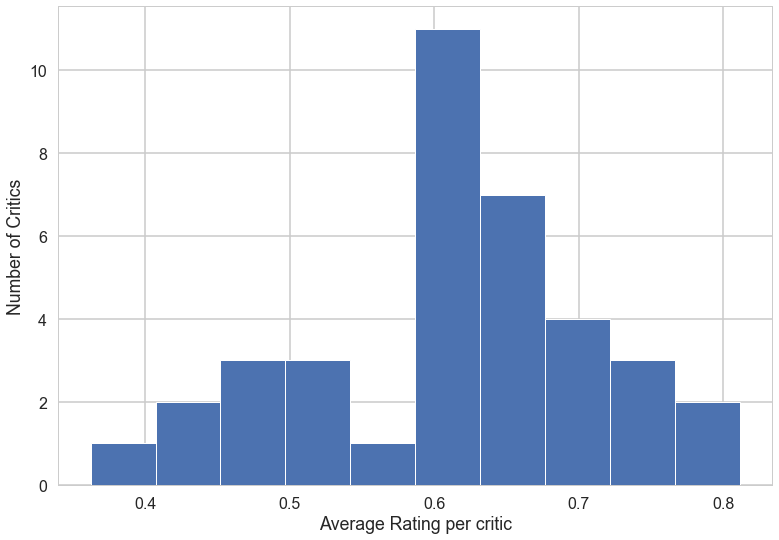

In [206]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

<div class="span5 alert alert-info">
<h3>Exercise Set I</h3>
<br/>
<b>Exercise:</b> Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?
</div>

In [207]:
s = means[counts > 100]
total = s.count()
mean = s.mean()
below_mean = s[s < 0.6].count()
half_or_less = s[s <= 0.5].count()
print "Total critics: ", total
print "Mean score: ", mean
print "Critics below the mean: ", below_mean
print "Critics below score 0.5: ", half_or_less
print "Min score: ", s.min()
print "Max score: ", s.max()

Total critics:  37
Mean score:  0.612399440543
Critics below the mean:  14
Critics below score 0.5:  6
Min score:  0.362068965517
Max score:  0.811403508772


Answer: The distribution mean is at approximately 0.61 and has a positive skew, meaning that critics tend to give more 'fresh' reviews than 'rotten' ones. Interestingy only 6 of the 37 critics have an average rating of 0.5 or less. Noting that the histogram takes into account critics with 100 or more reviews and reviews with a quote, the following remarks can be made:
- on average the critics feel the wuality of movies is relatively high
- the bad movies either do not get reviewed, or get reviewed more randomly by people who do not write many reviews
- the range of teh distribution os from 0.36 to 0.81, meaning that no critic gave uniformly high or low scores

## The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,0,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 
    15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 
    30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

In [208]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
[u'hop', u'off', u'on', u'pop']


In [209]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

## Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

<div class="span5 alert alert-info">
<h3>Exercise Set II</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?
</div>

In [210]:
#your turn
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB



In [211]:
# Split into training and test data sets
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3)


In [212]:
print X.shape, y.shape
print train_X.shape, train_y.shape
print test_X.shape, test_y.shape

(15561, 22417) (15561L,)
(10892, 22417) (10892L,)
(4669, 22417) (4669L,)


In [213]:
#Accuracy on the test and training dataset

clf1 = MultinomialNB().fit(train_X, train_y)
training_accuracy = clf1.score(train_X, train_y)
test_accuracy = clf1.score(test_X, test_y)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.921686
Accuracy on test data:     0.767830


Answer: The training accuracy is high at 92% and for test data far lower at 77%, indocting an overfit. Would prefer a higher test score even at the expense of a lower training score to have a more robust fit.

### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

<div class="span5 alert alert-info">
<h3>Exercise Set III</h3>

<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

In [214]:
# Your turn.

all_words = CountVectorizer().fit(critics.quote)
stops = all_words.stop_words_
print stops

#np.(counts, type='hist', bins = 100)
#plt.show()

set([])


In [215]:
type(X)

scipy.sparse.csc.csc_matrix

In [216]:
X.shape

(15561, 22417)

In [217]:
# sum the columns of X to get frequencies of each word
freq = X.sum(axis=0) 
freq.shape

(1L, 22417L)

In [218]:
ft = np.asarray(freq)
ftt = ft.T
ftt1 = ftt.flatten()
ftt1

array([ 8,  1, 10, ...,  3,  1,  1], dtype=int64)

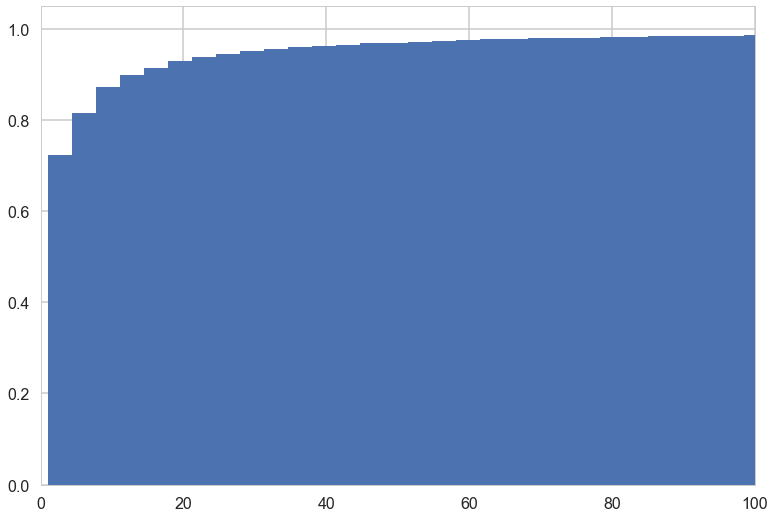

In [219]:
plt.hist(ftt1, bins=5000, cumulative=True, normed=True, log=False)
plt.axis(xmin = 0.0, xmax=100)
plt.axis(ymin = 0.0)
plt.show()

In [220]:
print ftt.min()
print ftt.max()
print ftt.mean()

1
16805
13.1780791364


In [221]:
ftt.T

array([[ 8,  1, 10, ...,  3,  1,  1]], dtype=int64)

In [222]:
len(ftt)

22417

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [223]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [224]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [225]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

In [226]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
min_dfs = [1, 2, 5, 10, 20, 50, 100, 200] # YOUR TURN: put your value of min_df here.

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:
        
        vectorizer = CountVectorizer(min_df=min_df)       
        Xthis, ythis = make_xy(critics, vectorizer)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
        # your turn
        clf2 = MultinomialNB(alpha = alpha).fit(Xtrainthis, ytrainthis)
        score = cv_score(clf2, Xtrainthis, ytrainthis, log_likelihood)
        if score > maxscore:
            maxscore = score
            best_alpha = alpha
            best_min_df = min_df
        print alpha, min_df, score

print "--------------------------"
print "best alpha: ", best_alpha
print "best min_df: ", best_min_df
print "best score: ", maxscore

0.1 1 -974.573904346
0.1 2 -977.76839955
0.1 5 -938.60759319
0.1 10 -809.544893815
0.1 20 -671.940302896
0.1 50 -605.17717055
0.1 100 -597.792718465
0.1 200 -601.226887046
1 1 -743.18586155
1 2 -634.410987038
1 5 -603.633139946
1 10 -584.523131667
1 20 -572.80349254
1 50 -584.550841362
1 100 -592.78818516
1 200 -600.079183142
5 1 -1311.72411112
5 2 -1037.94647972
5 5 -729.746194646
5 10 -593.344726347
5 20 -550.08162056
5 50 -565.876570456
5 100 -585.011209944
5 200 -596.74214604
10 1 -1473.92439093
10 2 -1270.56261482
10 5 -964.249618263
10 10 -748.04516299
10 20 -611.562352714
10 50 -571.727633379
10 100 -583.779923658
10 200 -595.079377168
50 1 -1422.66272105
50 2 -1366.66973775
50 5 -1255.66794006
50 10 -1130.80927295
50 20 -970.81758293
50 50 -759.30218142
50 100 -655.09814451
50 200 -616.283179478
--------------------------
best alpha:  5
best min_df:  20
best score:  -550.08162056


In [227]:
print("alpha: {}".format(best_alpha))
print("min_df: {}".format(best_min_df))

alpha: 5
min_df: 20


<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

In [228]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf2 = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf2.score(xtrain, ytrain)
test_accuracy = clf2.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.793532
Accuracy on test data:     0.713276


Answer: this result is less accurate on both the training and test data, but avoids overfit.

In [229]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf2.predict(xtest)))

[[2152 2109]
 [1014 5617]]


## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [230]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf2.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
('         masterpiece', '0.86')
('        entertaining', '0.85')
('           enjoyable', '0.84')
('                rare', '0.83')
('           excellent', '0.83')
('                best', '0.83')
('               among', '0.82')
('               years', '0.82')
('               sharp', '0.82')
('            touching', '0.82')
Bad words	     P(fresh | word)
('       disappointing', '0.28')
('          uninspired', '0.28')
('                lame', '0.28')
('                dull', '0.27')
('      disappointment', '0.26')
('               needs', '0.25')
('           pointless', '0.25')
('               empty', '0.24')
('         predictable', '0.21')
('               lacks', '0.20')


<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

</div>

Answer: this method isolates each word in the vocabulary and the probability in each row represents the predictive power of teh word (the proportion of positive/negative cases in which the word is used). Hence we know which words are strongly suggestive of a positive or negative review.

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [231]:
x, y = make_xy(critics, vectorizer)

prob = clf2.predict_proba(x)[:, 0]
predict = clf2.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
I know that Platoon is being acclaimed for its realism, and I expect to be chastened for being a woman finding fault with a war film. But I've probably seen as much combat as most of the men saying, 'This is how war is.'

Part comedy, part family drama, part romance, part special-effects mystery-adventure, and not entirely satisfying on any of these levels.

Mr. Peckinpah's least interesting, least personal film in years, a hysterically elaborate, made-in-Yugoslavia war spectacle, the work of international financiers and a multinational cast.

Walken is one of the few undeniably charismatic male villains of recent years; he can generate a snakelike charm that makes his worst characters the most memorable, and here he operates on pure style.

The Waterboy is arguably Sandler's most enjoyable motion picture to date, but it's still far from a masterpiece.

Mis-predicted Fresh quotes
--------------------------
At two hours and 45 minu

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>
</div>
</div>

In [232]:
#your turn
text = "This movie is not remarkable, touching, or superb in any way"
x_text = vectorizer.transform([text])
clf2.predict_proba(x_text)


array([[ 0.09763433,  0.90236567]])

In [233]:
clf2.classes_

array([0, 1])

Answer: 
NB: 0 == rotten, 1 == fresh.
So for the above sentence the prediction is 95% fresh, due to the use of words 'remarkable', 'touching' and 'superb', which fall in the 'good words' category. However, the bag-of-words approach does not pick up on the negation and therefore does not flip the meaning. This is a disadvantage of the bag-of-words approach. 

### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

<div class="span5 alert alert-info">
<h3>Exercise Set VIII: Enrichment</h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try a few of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result.
</div>

### TF-IDF Vectorizer

In [234]:
# Your turn

# TF-IDF vectorizer

# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer

In [235]:

tfidfvectorizer = TfidfVectorizer(min_df=20, stop_words=['movie', 'film', 'actor', 'actress'])
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)

# split the data into train and test using new X obtained from the vectorizer
xtrain, xtest, ytrain, ytest = train_test_split(Xtfidf, y, test_size=0.3)

clf3 = MultinomialNB(alpha=5).fit(xtrain, ytrain)

# Print the accuracy on the test and training dataset

training_accuracy = clf3.score(xtrain, ytrain)
test_accuracy = clf3.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.732831
Accuracy on test data:     0.702292


In [236]:
x_text = tfidfvectorizer.transform(["This movie is not remarkable, touching, or superb in any way"])
clf3.predict_proba(x_text)

array([[ 0.16288763,  0.83711237]])

TF_IDF provides a closer fit between training and test data, although the absolute accuracy is not improved. This looks like a more robust model. It also does slightly better in predicting a new review, though still fails to pick up on the negation as it is a bag-of-words method.

### Random Forest Classifier 

In [237]:
# Random forest classifier

from sklearn.ensemble import RandomForestClassifier

In [238]:
clf_rf = RandomForestClassifier(n_estimators=500, max_depth=200, min_samples_leaf = 10).fit(xtrain, ytrain)

# Print the accuracy on the test and training dataset

training_accuracy = clf_rf.score(xtrain, ytrain)
test_accuracy = clf_rf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.748806
Accuracy on test data:     0.669951


In [239]:
clf_rf.n_features_ # each word is a feature

1726

In [240]:
clf_rf.predict_proba(x_text)

array([[ 0.41019957,  0.58980043]])

The default RF classifier overfits, with 98% accuracy on training data and 66% on test data. Key parameters that can be changed are:
- number of trees (default = 10): default of 10 is too low, accuracy increases at 100+, at 500 takes ca. 20sec to run with marginal increase in accuracy
- max depth of a tree (default = none): for this exercise my findings are that depth=2 gives training and test accuracy of ca. 60%; model overfits at unlimited depth, 100-200 gave good results
- minimum samples in single leaf node (default = 1): overfits at 1, good results with 10, with 5 get accuracy of 68% but starts to overfit

-------------------------------------------------------------------------
A balanced result with no overfit:

- Accuracy on training data: 75.0%
- Accuracy on test data:     67.5%

With parameters: n_estimators=500, max_depth=200, min_samples_leaf = 10

-------------------------------------------------------------------------

Overall the RF classifier gave slightly worse results to the bag-of-words approah. The best result was achieved with the simplest CountVectorizer and K-fold function to tune parameters, with 80% training and 72% test accuracy. 

The RF model also works better on the new review sentence, but ultimately still fails the test as it classifies the sentence with 60% 'fresh' and 40% 'rotten'.

In [241]:
# perform the RF classifier again using the original vectorizer

train_X, test_X, train_y, test_y

clf_rf_1 = RandomForestClassifier(n_estimators=500, max_depth=100, min_samples_leaf = 5).fit(train_X, train_y)

# Print the accuracy on the test and training dataset

training_accuracy = clf_rf_1.score(train_X, train_y)
test_accuracy = clf_rf_1.score(test_X, test_y)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.697943
Accuracy on test data:     0.663097


In [242]:
clf_rf_1.n_features_ # more features than the TF-IDF vector

22417

With the original vectorizer (before df_min was introduced), the RF classifier has more features and takes longer to run and does not yield better results. It also seems to be less stable and results vary significantly more with changing with parameters. 

--------------------------------------------------------------
- Accuracy on training data: 70.4% 
- Accuracy on test data:     66.8% 

Parameters: n_estimators=500, max_depth=100, min_samples_leaf = 5

--------------------------------------------------------------

Reducing the number of features first prevents the model from drowning in detail.

### N-gram model with CountVectorizer

In [243]:
# use n-grams in CountVectorizer

vectorizer_ngram = CountVectorizer(min_df=20, ngram_range = (1,2))

X, y = make_xy(critics, vectorizer_ngram)

xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size=0.7)

clf4 = MultinomialNB(alpha=5).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf4.score(xtrain, ytrain)
test_accuracy = clf4.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.778094
Accuracy on test data:     0.739987


In [244]:
x_text = vectorizer_ngram.transform(["This movie is no good"])
clf4.predict_proba(x_text)

array([[ 0.68022256,  0.31977744]])

Results with bi-gram:
- Accuracy on training data: 77.9%
- Accuracy on test data:     73.5%

Tri-gram:
- Accuracy on training data: 78.2%
- Accuracy on test data:     73.3%

4-gram:
- Accuracy on training data: 78.1%
- Accuracy on test data:     72.6%

5-gram:
- Accuracy on training data: 77.8%
- Accuracy on test data:     73.7%

6-gram:
- Accuracy on training data: 78.9%
- Accuracy on test data:     73.2%

Bi-gram seems to work best as it is an improvement over the monogram with K-fold (80% training, 72% test). Increasing beyond bi-gram does not improve results and makes the model less scaleable.

With n-gram up to 6, the model still fails to pick up on the negation in the new review sentence. So it will take a large data set and a complex algorithm for the model to learn idioms such as "not .... in any way". A simpler sentence like "This movie is not good in any way" does get correctly predicted as 'rotten', but the test sentence is challenging because it has 3 strongly positive words that win over the negation picked up in "not superb". The bi-gram model correctly predicts "This movie is no good", but fails on "This movie is not good", but this is possibly due to the training data being relatively small.